# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. In this project, we will use a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews.  The model should achieve an F1 score of at least 0.85.

# Initialization

## Install or upgrade libraries

In [1]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade numpy

     |████████████████████████████████| 18.1 MB 6.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.0 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade scipy

     |████████████████████████████████| 55.6 MB 7.3 MB/s eta 0:00:012
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade smart-open

     |████████████████████████████████| 58 kB 1.1 MB/s eta 0:00:01
  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.1.0
    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-5.1.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --upgrade gensim

     |████████████████████████████████| 24.0 MB 6.2 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install tqdm=4.63.0

ERROR: Invalid requirement: 'tqdm=4.63.0'
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


## Imports

In [10]:
from catboost import CatBoostClassifier, CatBoostError
from collections import Counter
from gensim.models import Word2Vec
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from lightgbm import LGBMClassifier
from matplotlib import pyplot
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm.auto import tqdm

import gensim
import gensim.downloader
import hyperopt
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sklearn.metrics as metrics
import spacy
import string
import warnings

## Constants

In [11]:
CV = 5
FINDING_HYPERPARAMETERS = False
HYPEROPT_MAX_EVALS = 30
RANDOM_STATE = 42
SCORING = 'f1'
NUM_FEATURES = 300 # for word2vec

## Other initialization

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

In [13]:
plt.style.use('seaborn')

In [14]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [15]:
warnings.filterwarnings('ignore')

## Load Data

In [16]:
try: 
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Conclusion:  Initialization
In this section, we installed necessary libraries, defined constants, performed other initialization tasks, and loaded the IMDB movie reviews.

# Preliminary Data Review

In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [18]:
df_reviews.sample(5, random_state=RANDOM_STATE)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
11993,tt0043511,movie,Europe '51,Europa '51,1952,\N,118,0,Drama,7.5,3221,Poor Ingrid suffered and suffered once she wen...,4,neg,0,train,10692
12486,tt0067085,movie,Fata Morgana,Fata Morgana,1971,\N,76,0,"Comedy,Documentary,Drama",6.8,3337,"As one other IMDb reviewer puts it, ""...imagin...",8,pos,1,test,3090
39075,tt0362820,movie,The Librarians,The Librarians,2003,\N,96,0,"Action,Thriller",5.2,356,"Like a terrible cancer raining out of the sky,...",1,neg,0,test,293
6230,tt0180590,video,Camp Fear,Camp Fear,1991,\N,86,0,"Horror,Romance,Sci-Fi",3.8,245,This movie starts out the way every movie shou...,3,neg,0,test,1786
12781,tt0087258,movie,Final Justice,Final Justice,1985,\N,90,0,"Action,Crime,Drama",2.2,2973,"I've never been impressed by JD anyway, and Fi...",2,neg,0,train,3184


## Conclusion: Prelim data review
The IMDB dataset has more than 47,000 reviews.  There are no missing values in the columns we will be using:  `review` (the text of the review), `pos` (polarity, positive or negative), and `ds_part` (for splitting into training and test sets).

# EDA

Let's check the number of movies and reviews over years.

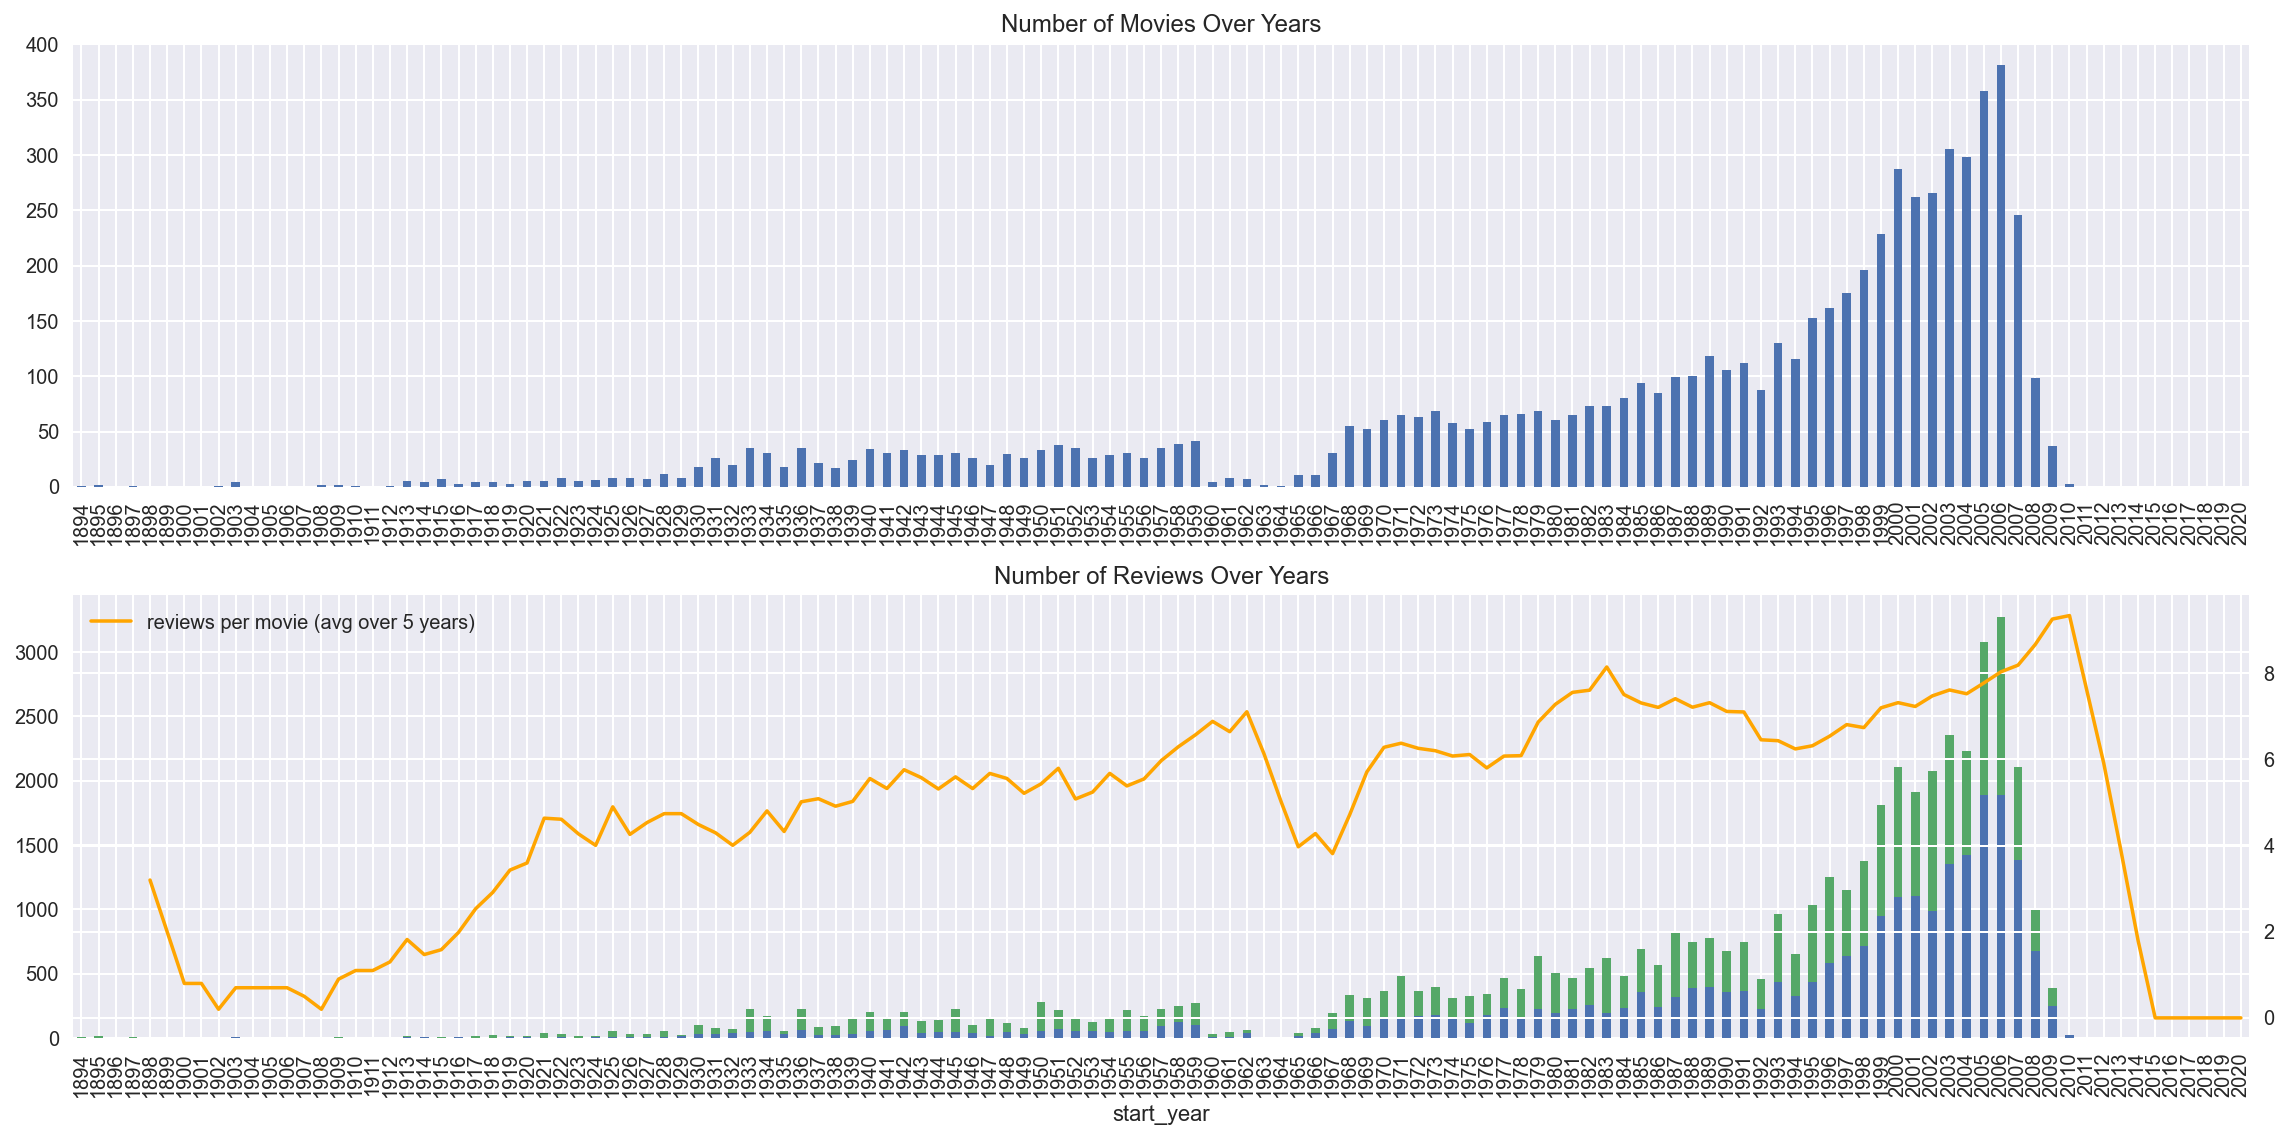

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The number of movies has increased over the years, as has the number of reviews.  The polarity is split pretty evenly between positive and negative reviews.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

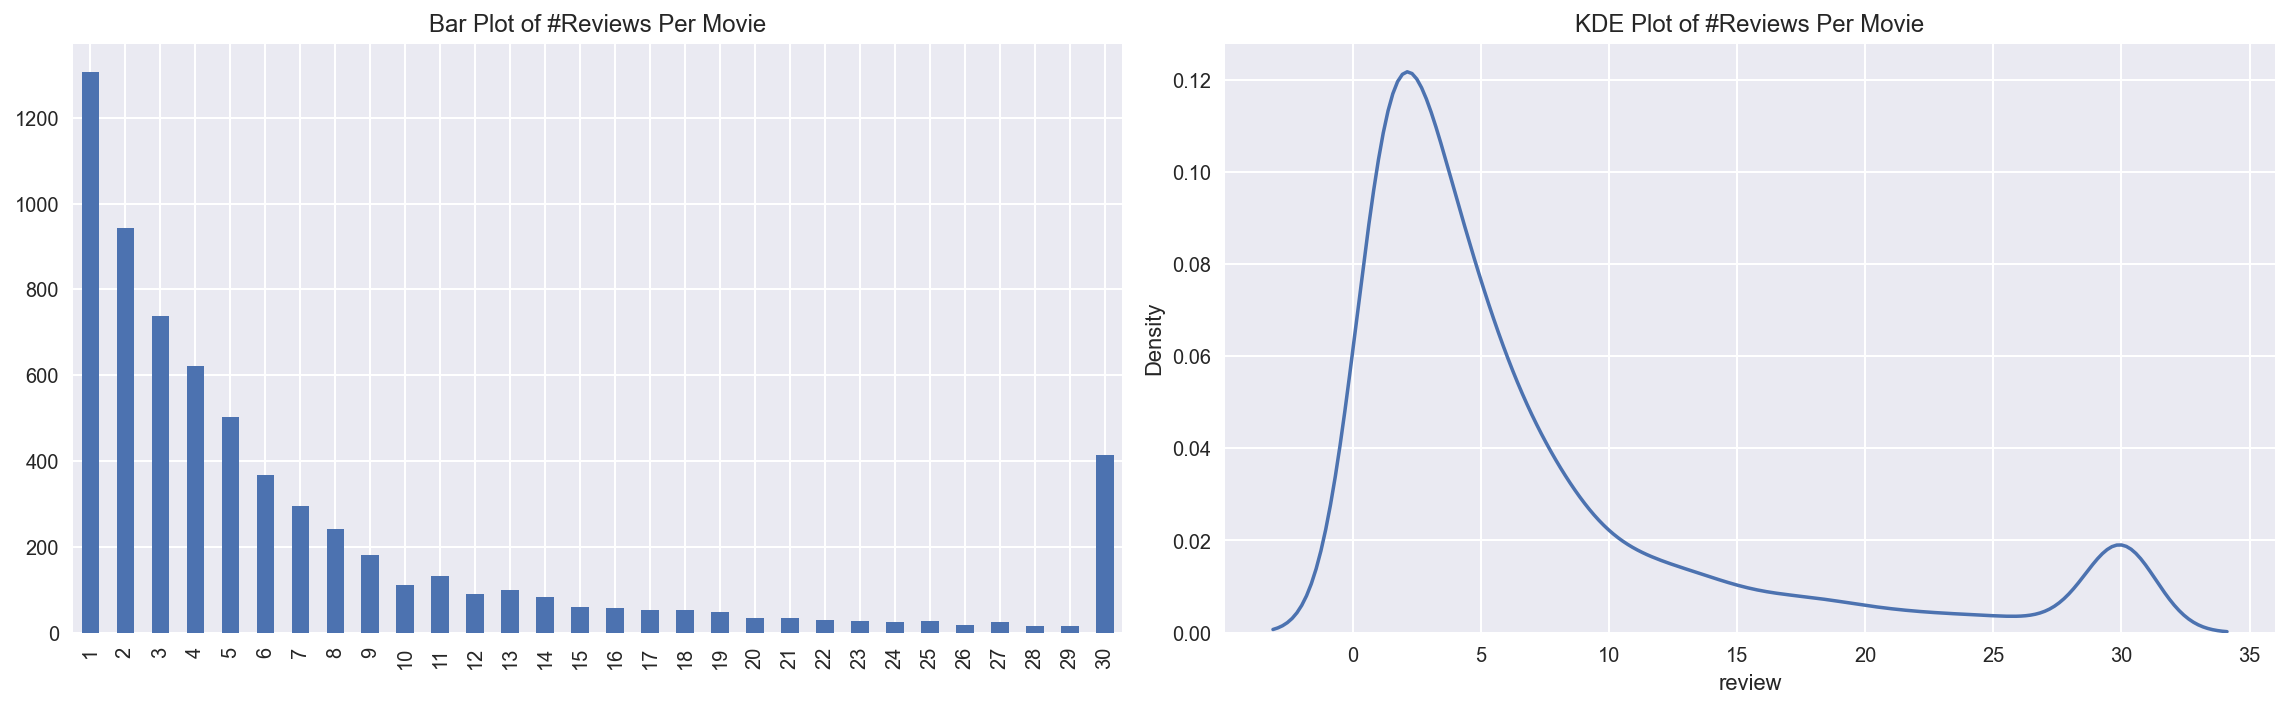

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

There are about 5 reviews per movie, on average.  The distribution is skewed to the right, meaning that there is a relatively small number of movies that have a large number of reviews (e.g., 30 per movie).  These are probably "blockbusters."

In [21]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Our classes are balanced.

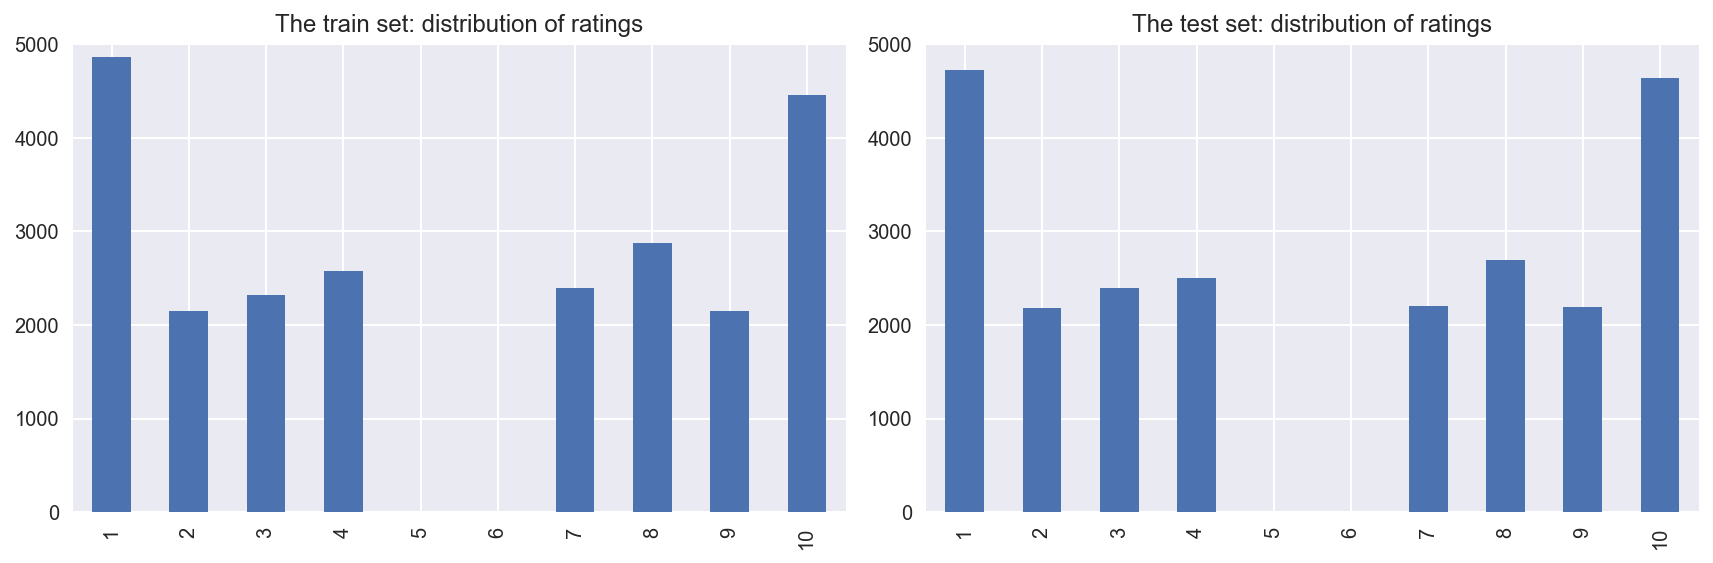

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Movies were initially rated on a 10-point scale.  Ratings of 1-4 were assigned a polarity of 0; ratings of 7-10 were assigned a 1.  The distribution of underlying rating is similar for the training and test sets.

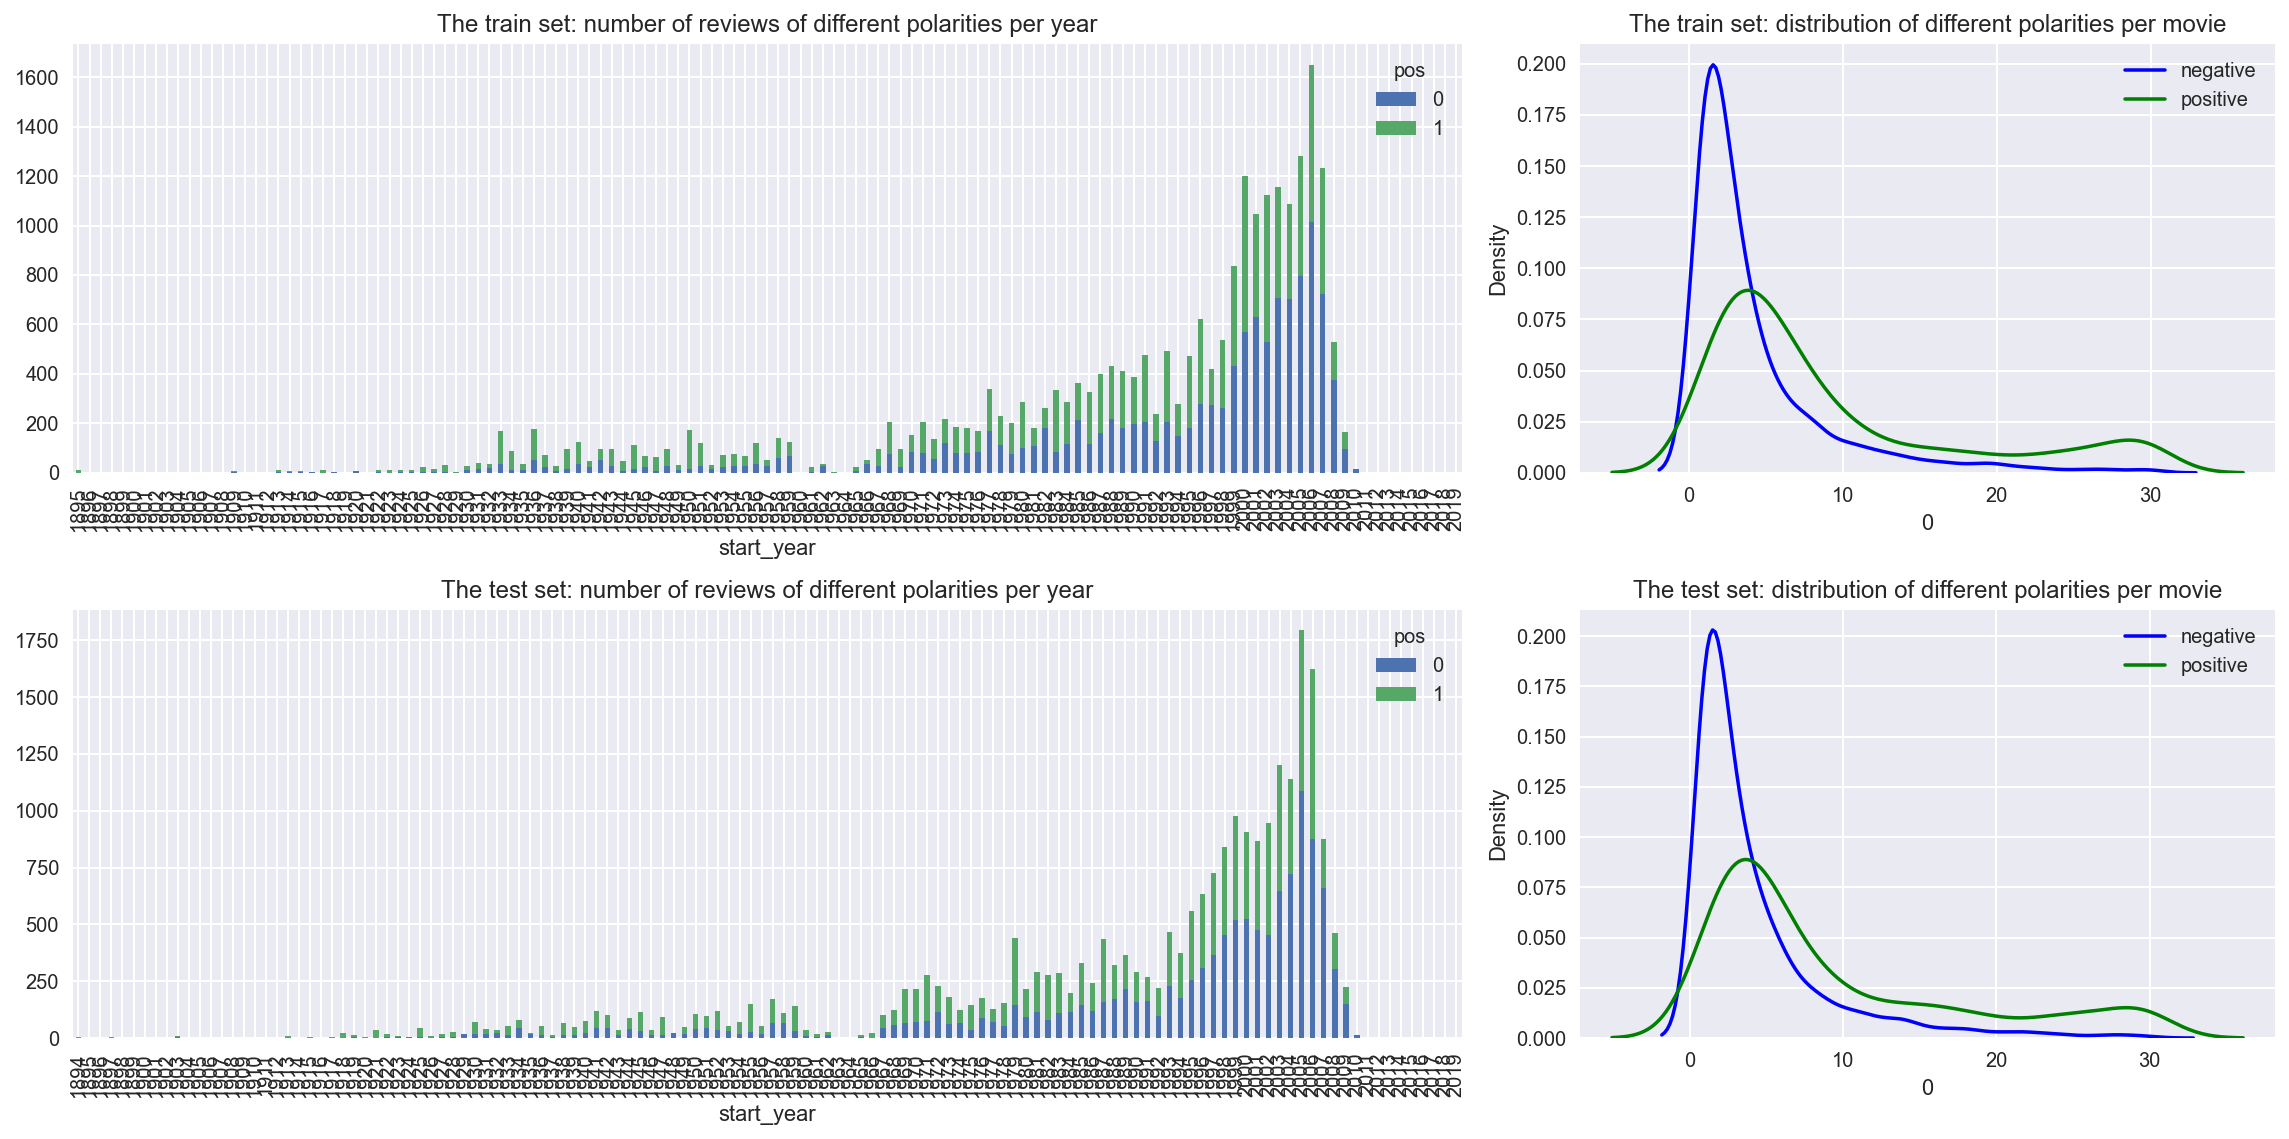

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The training and test sets are also balanced in terms of reviews per year and polarity per year.

## Conclusion: EDA
In this section, we created several plots to examine the numbers of movies per year, reviews per year, and polarities per year.  We found that our classes are balanced, and the training and test sets are similar.

# Feature preprocessing

## Normalization

We assume all models below accept texts in lowercase and without any digits, punctuations marks etc.

In [24]:
# Remove all characters that aren't English alphabet or apostrophe, and convert to lower case
def clear_text(text):
    pattern = r"[^A-z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    return ' '.join(text).lower()

In [25]:
df_reviews['review_norm'] = df_reviews['review'].progress_apply(clear_text)
df_reviews['review_norm'].sample(5, random_state=RANDOM_STATE)

  0%|          | 0/47331 [00:00<?, ?it/s]

11993    poor ingrid suffered and suffered once she wen...
12486    as one other imdb reviewer puts it imagine a s...
39075    like a terrible cancer raining out of the sky ...
6230     this movie starts out the way every movie shou...
12781    i've never been impressed by jd anyway and fin...
Name: review_norm, dtype: object

The `clear_text()` method was written to convert the reviews to lower case and remove punctuation.

## Tokenization/lemmatization

### NLTK

In [26]:
stop_words = set(nltk_stopwords.words('english'))

In [27]:
def lemmatize_nltk(text):
    tokens = nltk.word_tokenize(text)
    #tokens = text.split()
    lemmas = [WordNetLemmatizer().lemmatize(t, pos='v') for t in tokens if t not in stop_words]
    return ' '.join(lemmas)

In [28]:
df_reviews['review_nltk'] = df_reviews['review_norm'].progress_apply(lemmatize_nltk)
df_reviews['review_nltk'].sample(5, random_state=RANDOM_STATE)

  0%|          | 0/47331 [00:00<?, ?it/s]

11993    poor ingrid suffer suffer go italy tire hollyw...
12486    one imdb reviewer put imagine space odyssey de...
39075    like terrible cancer rain sky wander crock mov...
6230     movie start way every movie start bunch hot ba...
12781    've never impress jd anyway final justice n't ...
Name: review_nltk, dtype: object

### SpaCy

In [34]:
# It was necessary to execute this from a command prompt first:
# python -m spacy download en_core_web_sm
# python -m spacy download en

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
def lemmatize_spacy(text):
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [36]:
df_reviews['review_spacy'] = df_reviews['review_norm'].progress_apply(lemmatize_spacy)
df_reviews['review_spacy'].sample(5, random_state=RANDOM_STATE)

  0%|          | 0/47331 [00:00<?, ?it/s]

11993    poor ingrid suffer suffer go italy tired holly...
12486    imdb reviewer put imagine space odyssey desert...
39075    like terrible cancer rain sky wander crock mov...
6230     movie start way movie start bunch hot babe dor...
12781    impress jd final justice see prior mst k airin...
Name: review_spacy, dtype: object

Using the normalized text from the previous section, we tokenized and lemmatized the text usng both the NLTK and SpaCy libraries.  In a later section, we will train models using the output from both libraries and compare the results.

## Train/test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [37]:
df_reviews_train = df_reviews.query('ds_part == "train"')
df_reviews_test = df_reviews.query('ds_part == "test"')

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

In [38]:
X_train_nltk = df_reviews_train['review_nltk']
X_test_nltk = df_reviews_test['review_nltk']

In [39]:
X_train_spacy = df_reviews_train['review_spacy']
X_test_spacy = df_reviews_test['review_spacy']

## Conclusion: Feature preprocessing
In this section, we normalized the text, i.e., converted it to lower case and stripped punctuation.  Then we tokenized and lemmatized the text using the NLTK and SpaCy libraries.

# Shared Functions

## Model evaluation

Composing an evaluation routine which can be used for all models in this project

In [40]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Printing model evaluation

In [41]:
def print_eval(model, data):
    
    # model - a dictionary describing the model (e.g., models['Logistic Regression'])
    # data - a tuple with order: X_train, X_test, y_train, y_test
    
    print(model['clf'])
    print()

    best_model = model['clf']
    best_params = model['best_params']
    
    try:
        best_params.update(model['other_params'])
        best_model.set_params(**best_params)
        best_model.fit(data[0], data[2])
    except CatBoostError as e:
        # CatBoost complains if we try to update parameters of fitted model
        #print(repr(e))
        pass
            
    #print('Parameters: {}'.format(best_params))
    #print()

    evaluate_model(best_model, data[0], data[2], data[1], data[3])

## Hyperopt parameter search

In [42]:
def do_hyperopt(models, data):
    
    # models - a dictionary defining the models and search spaces
    # data - a tuple with order: X_train, X_test, y_train, y_test
    # Note: Behavior affected by global: FINDING_HYPERPARAMETERS
    
    for model_name, model in models.items():
        print(model_name)
        print('-'*len(model_name))
        
        if FINDING_HYPERPARAMETERS:
            print('Finding hyperparameters...')
            print()
            

            def objective(params):
                clf = model['clf']
                params.update(model['other_params'])
                clf.set_params(**params)
                #print('Testing parameters: ', params)
                scores = cross_val_score(clf, data[0], data[2], cv=CV, scoring=SCORING, error_score='raise')
                best_score = max(scores)
                #print('Best score: ', best_score)
                loss = 1 - best_score
                return {'loss' : loss, 'params' : params, 'status' : STATUS_OK}
        
            best = fmin(fn=objective,
                        space=model['space'], 
                        algo=tpe.suggest, 
                        max_evals=HYPEROPT_MAX_EVALS, 
                        trials=model['trials'], 
                        verbose=True)

            model['best_params'] = space_eval(model['space'], best)
        else:
            print('Using default hyperparameters:')
            model['best_params'] = model['default_space']
            
        print(model['best_params'])
        print()

## Saving best models

In [43]:
best_models = {}

## Conclusion: Shared functions
In this section, we defined shared functions for evaluating models, printing the evaluation, and for hyperparameter search using hyperopt.

# Sentiment Analysis Models

## Constant model

In [44]:
dummy_classifier = DummyClassifier()
clf = dummy_classifier.fit(X_train_nltk, y_train)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


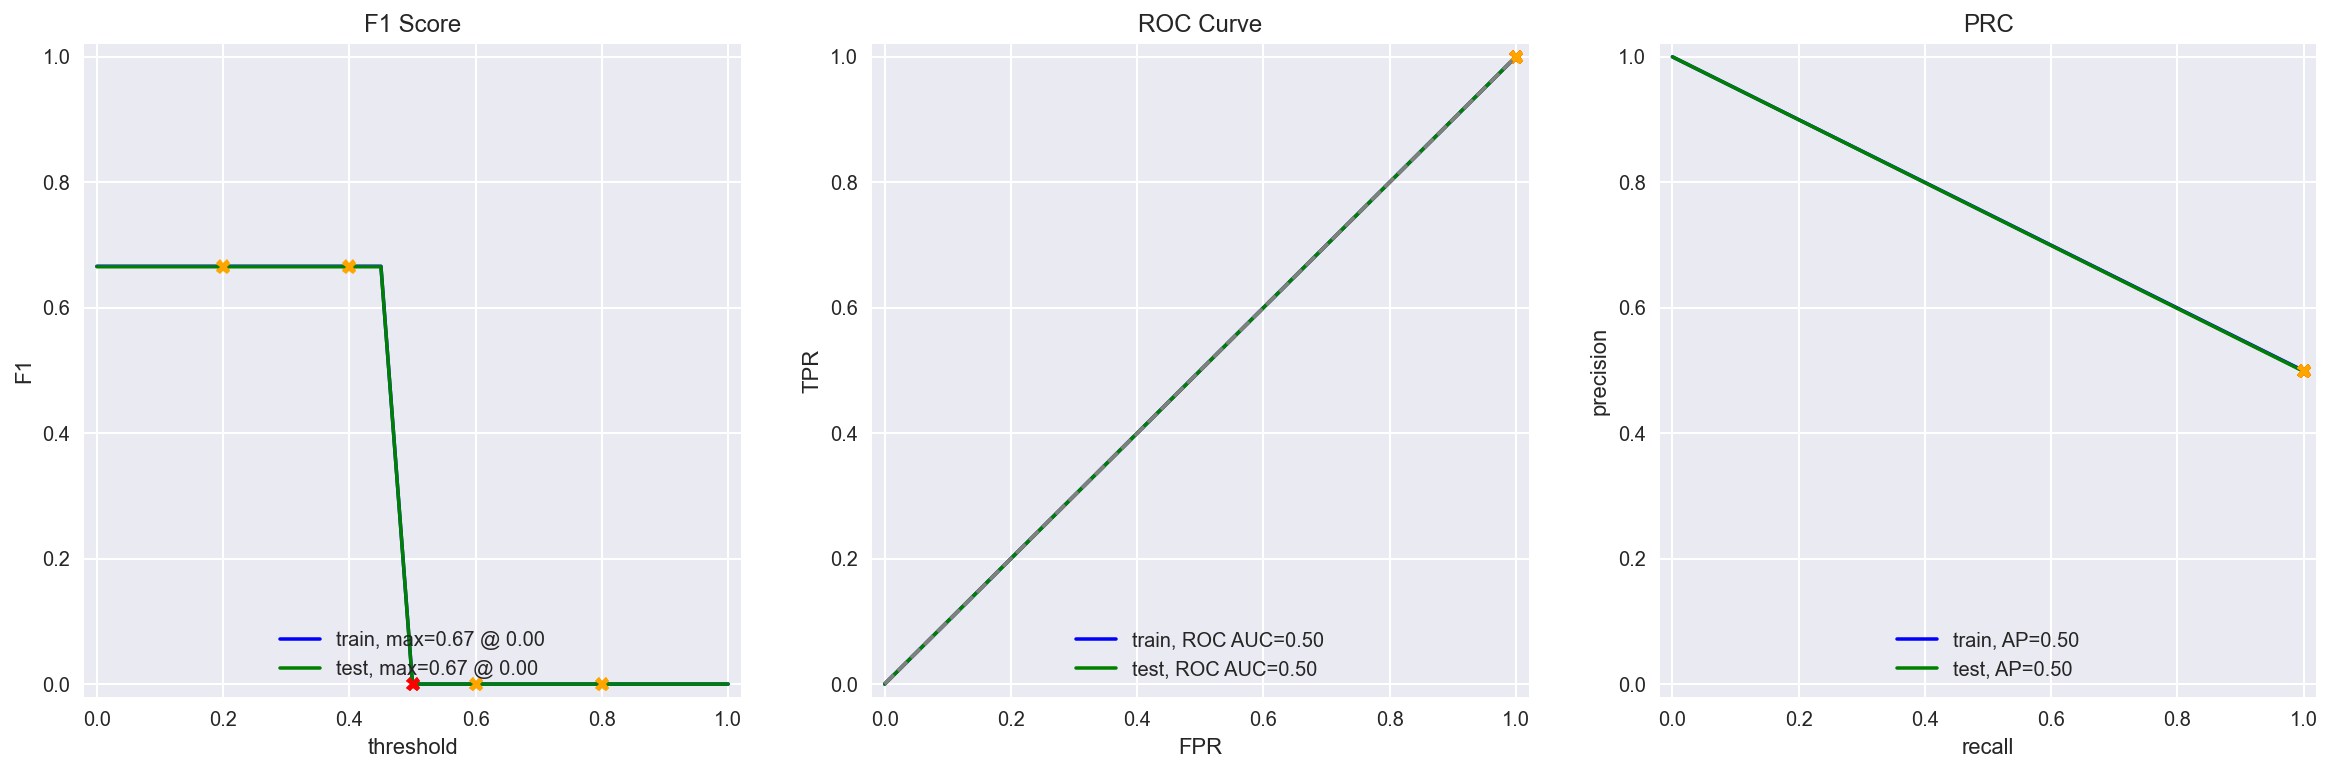

In [45]:
evaluate_model(clf, X_train_nltk, y_train, X_test_nltk, y_test)

The dummy classifier serves as a simple baseline to compare against other more complex classifiers.  By default, the dummy classifier always returns the most frequent class observed in the y argument, and since our classes are balanced, this achieves an accuracy of 0.5 and an F1 score of 0.0.  Also, as expected, the ROC curve is a perfectly diagonal line, consistent with random classification and an AUC of 0.5.

## Bag of words and TF-IDF

In [46]:
vectorizers = { 'Bag of Words' : CountVectorizer(), 
                'TF-IDF' : TfidfVectorizer()
              }
pre_processors = { 'nltk' : [X_train_nltk, X_test_nltk],
                   'spacy' : [X_train_spacy, X_test_spacy]
                 }
results = {}
logit = LogisticRegression()

In [47]:
for vname, vectorizer in vectorizers.items():
    results[vname] = []
    for pname, data in pre_processors.items():
        train_features = vectorizer.fit_transform(data[0])
        test_features = vectorizer.transform(data[1])
        logit.fit(train_features, y_train)
        y_hat = logit.predict(test_features)
        f1 = f1_score(y_test, y_hat)
        results[vname].append(f1)

In [48]:
pd.DataFrame(results, index=pre_processors)

,Bag of Words,TF-IDF
nltk,0.856185,0.881326
spacy,0.845378,0.874846


In [49]:
X_train = X_train_nltk
X_test = X_test_nltk

### Save to list of best models
We will save the Bag of Words model for later use.  We will develop tuned a TF-IDF model in the next section, so we will not save the current TF-IDF model.

In [50]:
vectorizer = CountVectorizer().fit(X_train_nltk)
classifier = logit.fit(vectorizer.transform(X_train_nltk), y_train)

best_models['Bag of Words'] = {'vectorizer' : vectorizer, 'classifier' : classifier}

In this section, we started with the text preprocessed with NLTK and SpaCy, then vectorized the text using bag of words and TF-IDF, and made predictions using a non-optimized logistic regression classifier.  As expected, TF-IDF outperformed the simpler bag of words model.  Also, the text preprocessed with NLTK outperformed the text preprocessed with SpaCy.  For this reason, we will use the NLTK text in subsequent sections.

## TF-IDF

### Feature vectorization

In [51]:
tf_idf = TfidfVectorizer() 
X_train_tfidf = tf_idf.fit_transform(X_train) 
X_test_tfidf = tf_idf.transform(X_test) 

### Hyperparameter tuning

In [52]:
models = {
    'Logistic Regression' : {
        'clf' : LogisticRegression(),
        'space' : {
            'max_iter' :     hp.choice('max_iter', range(100, 2000, 100)),
            'penalty' :      hp.choice('penalty', ['l1', 'l2']),
            'class_weight' : hp.choice('class_weight', [None, 'balanced']),
            'C' :            hp.loguniform('C', -3, 1)
        },
        # f1 = 0.88
        'default_space' : {'C': 1.204038296747592,
                           'class_weight': 'balanced',
                           'max_iter': 1700,
                           'penalty': 'l2'
        },
        'other_params' : {
            'random_state' : RANDOM_STATE,
            'solver' : 'liblinear'
        },
        'best_params' : {},
        'trials' : Trials()
    },
    # f1 = 0.88
    'LGBM' : {
        'clf' : LGBMClassifier(),
        'space' : {
            'learning_rate':    hp.loguniform('learning_rate', -3, 0),
            'max_depth':        hp.choice('max_depth', np.arange(2, 10, 1, dtype=int)),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
            'n_estimators':     hp.choice('n_estimators', np.arange(10, 2000, 10, dtype=int)),
            'subsample':        hp.uniform('subsample', 0.2 , 1)
        },
        'default_space' : {'colsample_bytree': 0.9629819060770827,
                           'learning_rate': 0.056587817081919775,
                           'max_depth': 7,
                           'n_estimators': 1840,
                           'subsample': 0.5792117421574401
        },
        'other_params' : {
            'random_state' : RANDOM_STATE
        },
        'best_params' : {},
        'trials' : Trials()
    }
}

In [53]:
do_hyperopt(models, (X_train_tfidf, X_test_tfidf, y_train, y_test))

Logistic Regression
-------------------
Using default hyperparameters:
{'C': 1.204038296747592, 'class_weight': 'balanced', 'max_iter': 1700, 'penalty': 'l2'}

LGBM
----
Using default hyperparameters:
{'colsample_bytree': 0.9629819060770827, 'learning_rate': 0.056587817081919775, 'max_depth': 7, 'n_estimators': 1840, 'subsample': 0.5792117421574401}



### Model evaluation

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


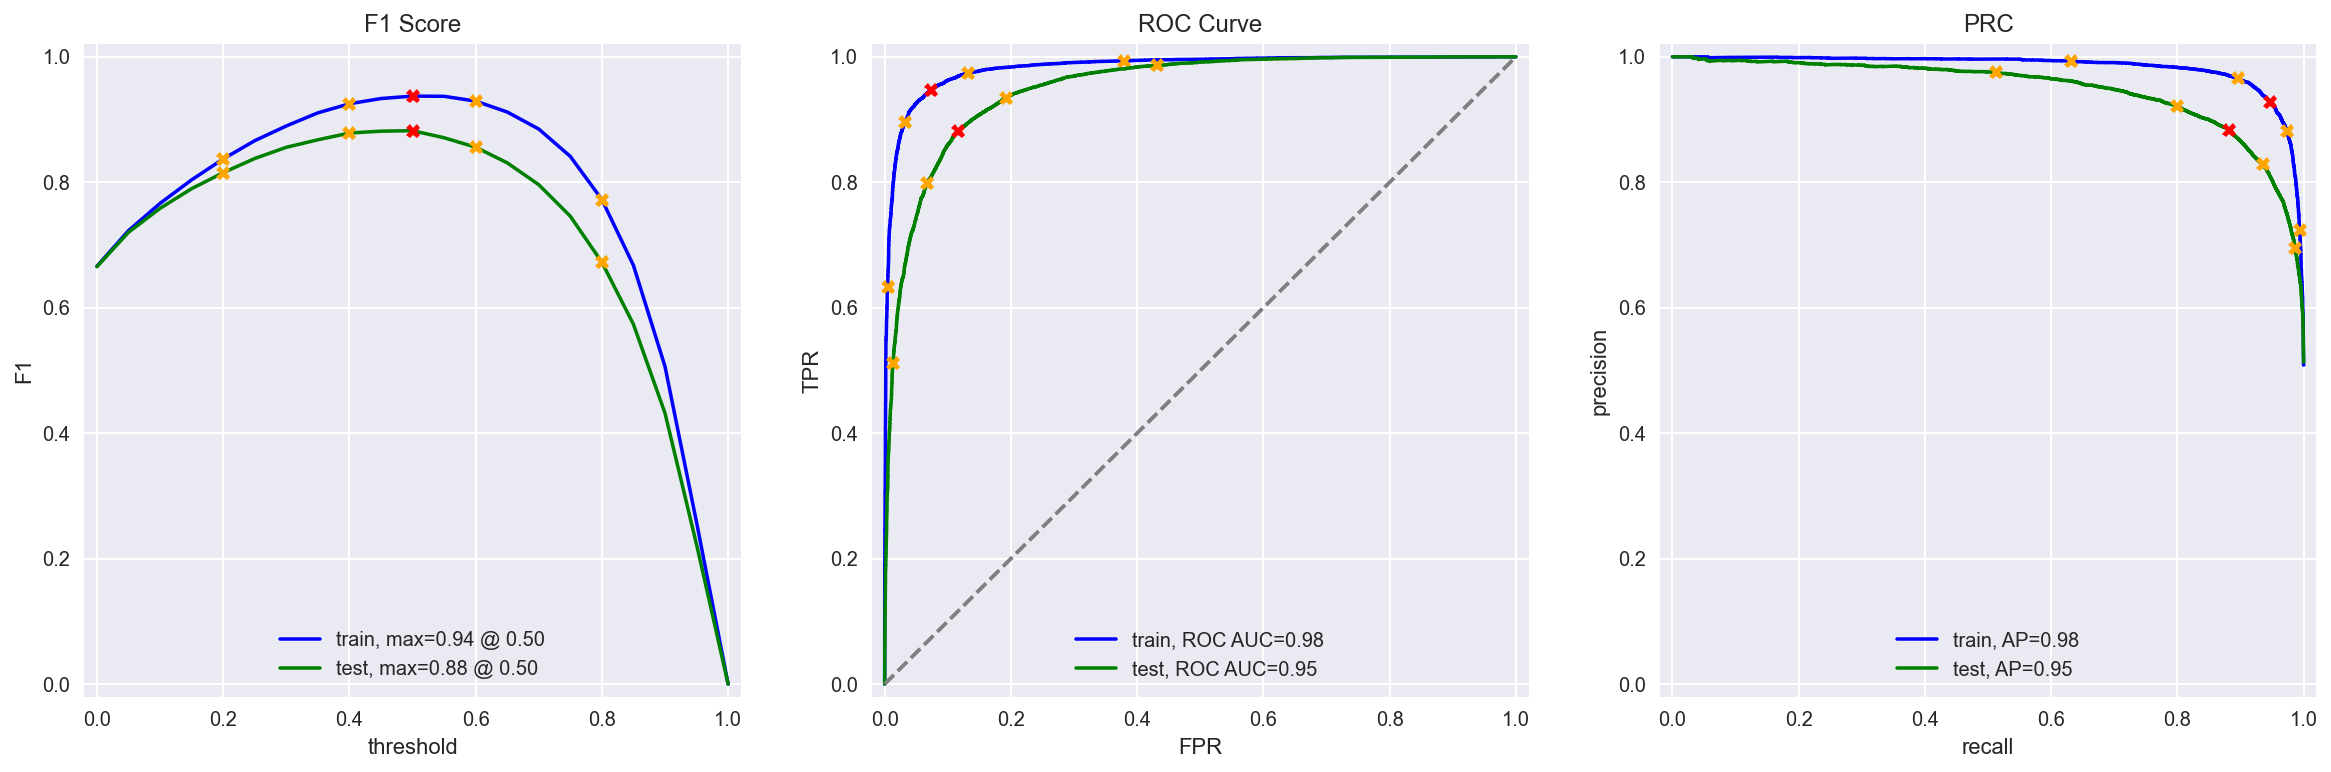

In [54]:
print_eval(models['Logistic Regression'], (X_train_tfidf, X_test_tfidf, y_train, y_test))

LGBMClassifier()

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


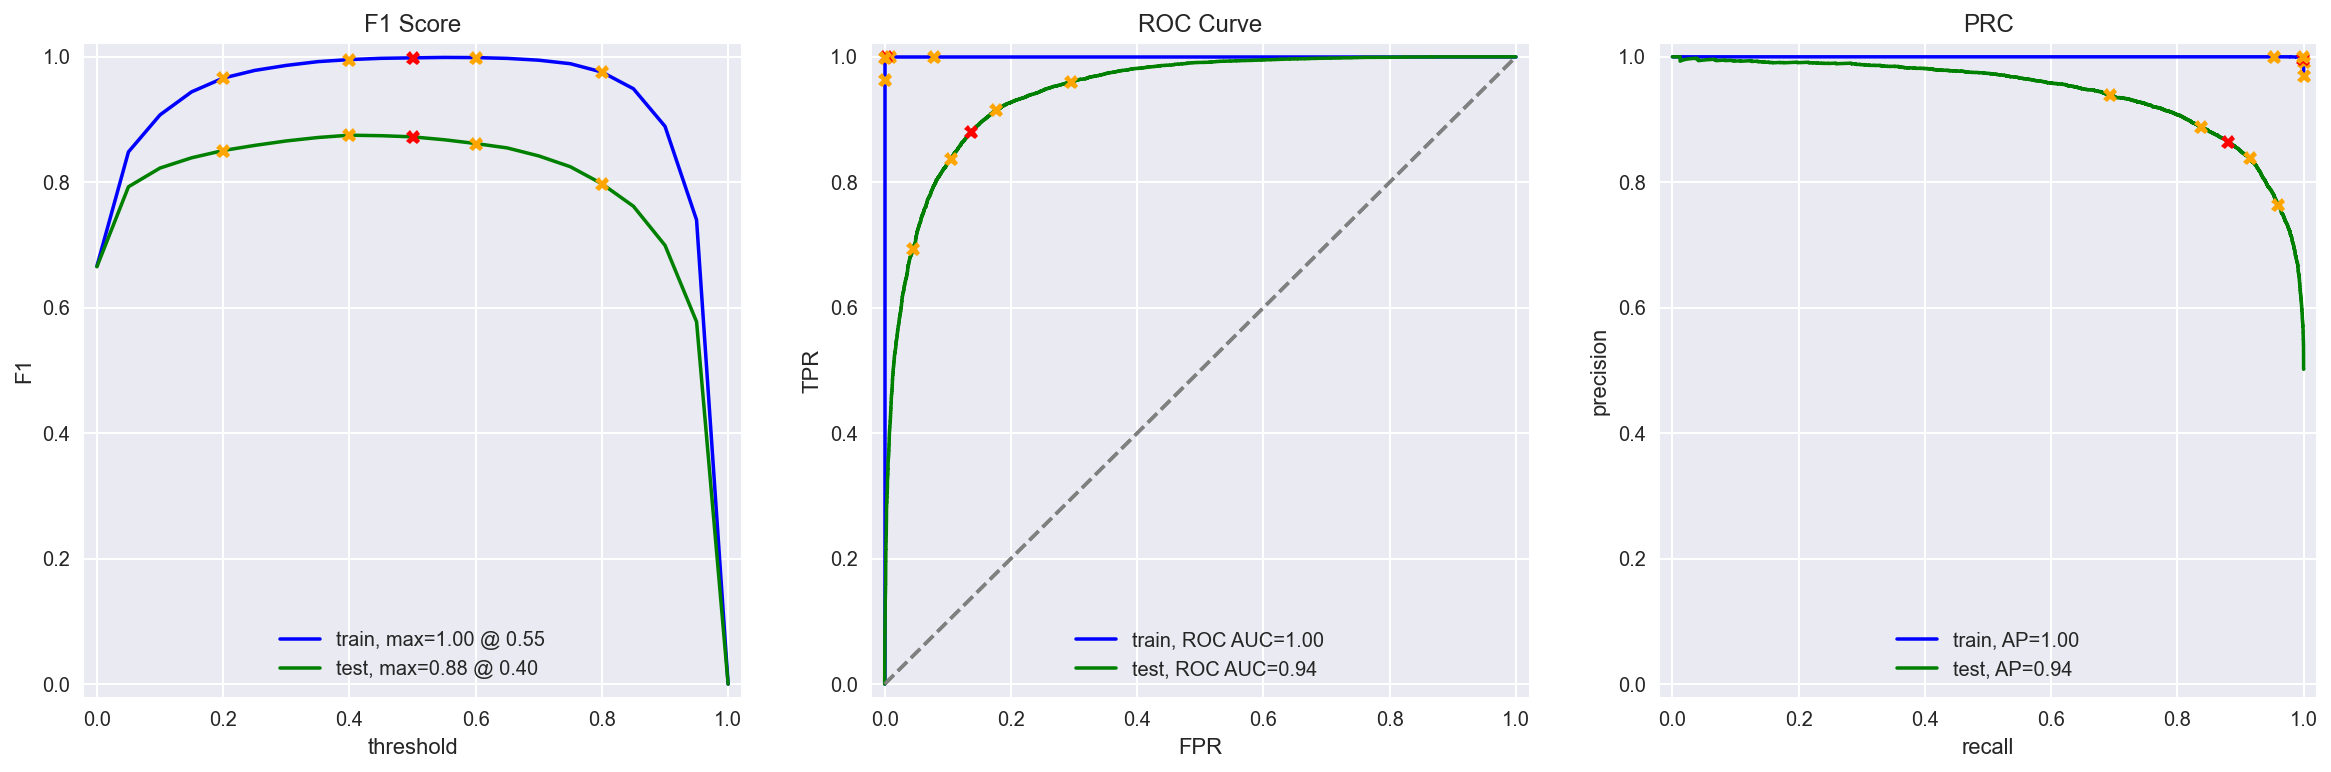

In [55]:
print_eval(models['LGBM'], (X_train_tfidf, X_test_tfidf, y_train, y_test))

### Save to list of best models

In [56]:
vectorizer = TfidfVectorizer().fit(X_train_nltk)

best_params = models['Logistic Regression']['best_params']
best_params.update(models['Logistic Regression']['other_params'])

best_tfidf = models['Logistic Regression']['clf']
best_tfidf.set_params(**best_params)
best_tfidf.fit(X_train_tfidf, y_train)

best_models['TF-IDF'] = {'vectorizer' : vectorizer, 'classifier' : best_tfidf}

In this section, we vectorized the NLTK-preprocessed text using TF-IDF, and we made predictions using tuned logistic regression and LighGBM classifiers.  Both models exceeded the benchmark F1 score of 0.86, with the logistic regression *slightly* outperforming the gradient boosting model.  Interestingly, the improvement from hyperparameter tuning was *very* small difference compared with the "out of the box" logistic regression classifier used in the previous section.

## Word2Vec

### Preprocessing

In [57]:
df_reviews['review_w2v'] = df_reviews['review'].progress_apply(gensim.utils.simple_preprocess)

  0%|          | 0/47331 [00:00<?, ?it/s]

### Vectorization model

#### Build

In [58]:
all_reviews = list(df_reviews['review_w2v'].values)
#all_reviews

In [59]:
model = Word2Vec(sentences = all_reviews,
                 workers = 4,
                 vector_size = NUM_FEATURES,
                 min_count = 30,
                 window = 10,
                 sample = 1e3)

#model.save("word2vec.model")

In [60]:
model.wv.vectors.shape

(14869, 300)

#### Test

In [61]:
vector = model.wv['acting']  # get numpy vector of a word
sims = model.wv.most_similar('acting', topn=5)  # get other similar words
sims

[('direction', 0.6310679912567139),
 ('directing', 0.6027705669403076),
 ('casting', 0.5922379493713379),
 ('writing', 0.5672010779380798),
 ('performances', 0.5630972385406494)]

In [62]:
vector = model.wv['quentin']
sims = model.wv.most_similar('quentin', topn=5)
sims

[('tarantino', 0.7743930220603943),
 ('scorsese', 0.735630452632904),
 ('tobe', 0.7191128134727478),
 ('dante', 0.699081540107727),
 ('landis', 0.6752012968063354)]

### Feature vectorization

In [63]:
def vectorize_review(review):
    featureVec = np.zeros(NUM_FEATURES, dtype="float32")
    index2word_set = set(model.wv.index_to_key)
    nwords = 0
    
    for word in review:
        if word in index2word_set:
            nwords += 1
            featureVec = np.add(featureVec, model.wv[word])
                
    featureVec = np.divide(featureVec, nwords)

    return pd.Series(featureVec)

In [64]:
X_train_w2v = df_reviews.query('ds_part == "train"')['review_w2v'].apply(vectorize_review)

In [65]:
X_test_w2v = df_reviews.query('ds_part == "test"')['review_w2v'].apply(vectorize_review)

### Hyperparameter tuning

In [66]:
models = { 
    'Logistic Regression' : {
        'clf' : LogisticRegression(),
        'space' : {
            'max_iter' :     hp.choice('max_iter', range(100, 2000, 100)),
            'penalty' :      hp.choice('penalty', ['l1', 'l2']),
            'class_weight' : hp.choice('class_weight', [None, 'balanced']),
            'C' :            hp.loguniform('C', -3, 1)
        },
        # f1 = 0.88
        'default_space' : {'C': 0.20319824908978754, 
                           'class_weight': None, 
                           'max_iter': 1500, 
                           'penalty': 'l2'
        },
        'other_params' : {
            'random_state' : RANDOM_STATE,
            'solver' : 'liblinear'
        },
        'best_params' : {},
        'trials' : Trials()
    },
    'CatBoost' : {
        'clf' : CatBoostClassifier(),
        'space' : {
            #'learning_rate':          hp.loguniform('learning_rate', -4, 0),
            'iterations':             hp.choice('iterations', np.arange(10, 1500, 50, dtype=int)),
            'depth':                  hp.choice('depth', np.arange(4, 10, 1, dtype=int)),
        },
        'default_space' : { 'depth': 8, 'iterations': 1110 },
        'other_params' : {
            'random_state' : RANDOM_STATE,
            'loss_function' : 'Logloss',
            'eval_metric' : 'F1',
            'logging_level' : 'Silent',
        },
        'best_params' : {},
        'trials' : Trials()
    }    
}

In [67]:
do_hyperopt(models, (X_train_w2v, X_test_w2v, y_train, y_test))

Logistic Regression
-------------------
Using default hyperparameters:
{'C': 0.20319824908978754, 'class_weight': None, 'max_iter': 1500, 'penalty': 'l2'}

CatBoost
--------
Using default hyperparameters:
{'depth': 8, 'iterations': 1110}



### Model evaluation

LogisticRegression()

          train  test
Accuracy   0.88  0.88
F1         0.88  0.87
APS        0.94  0.94
ROC AUC    0.94  0.94


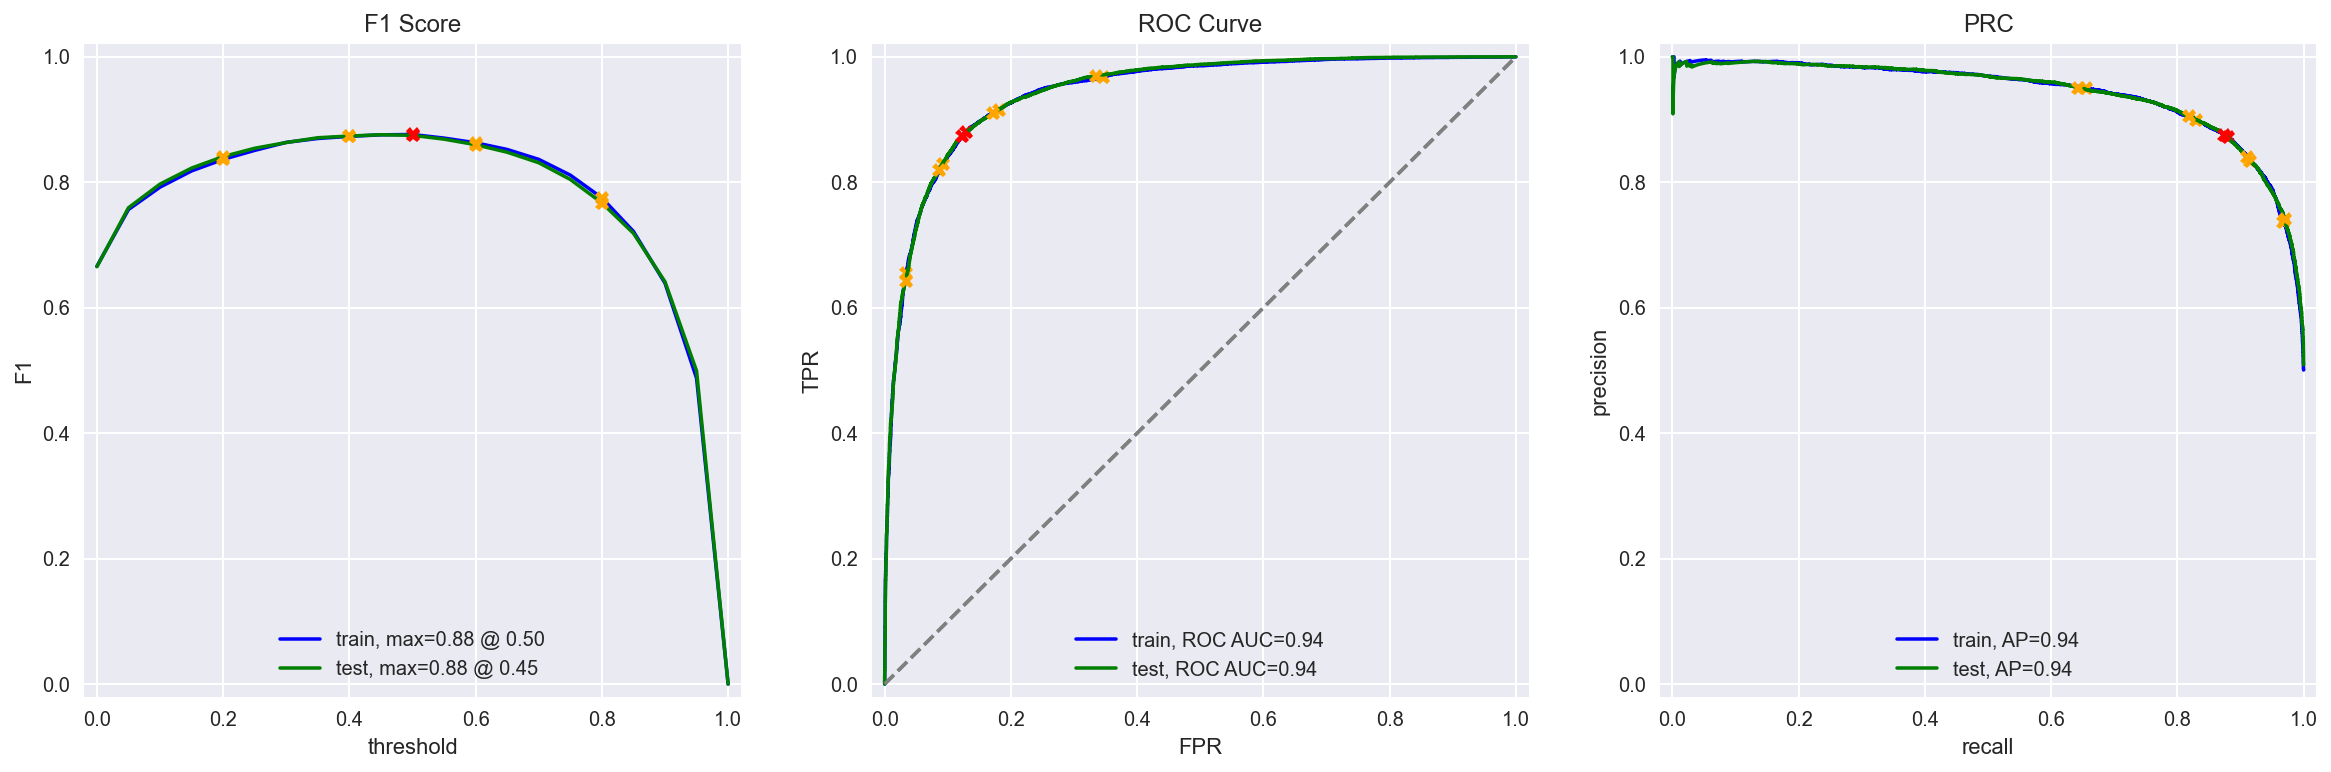

In [68]:
print_eval(models['Logistic Regression'], (X_train_w2v, X_test_w2v, y_train, y_test))


          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


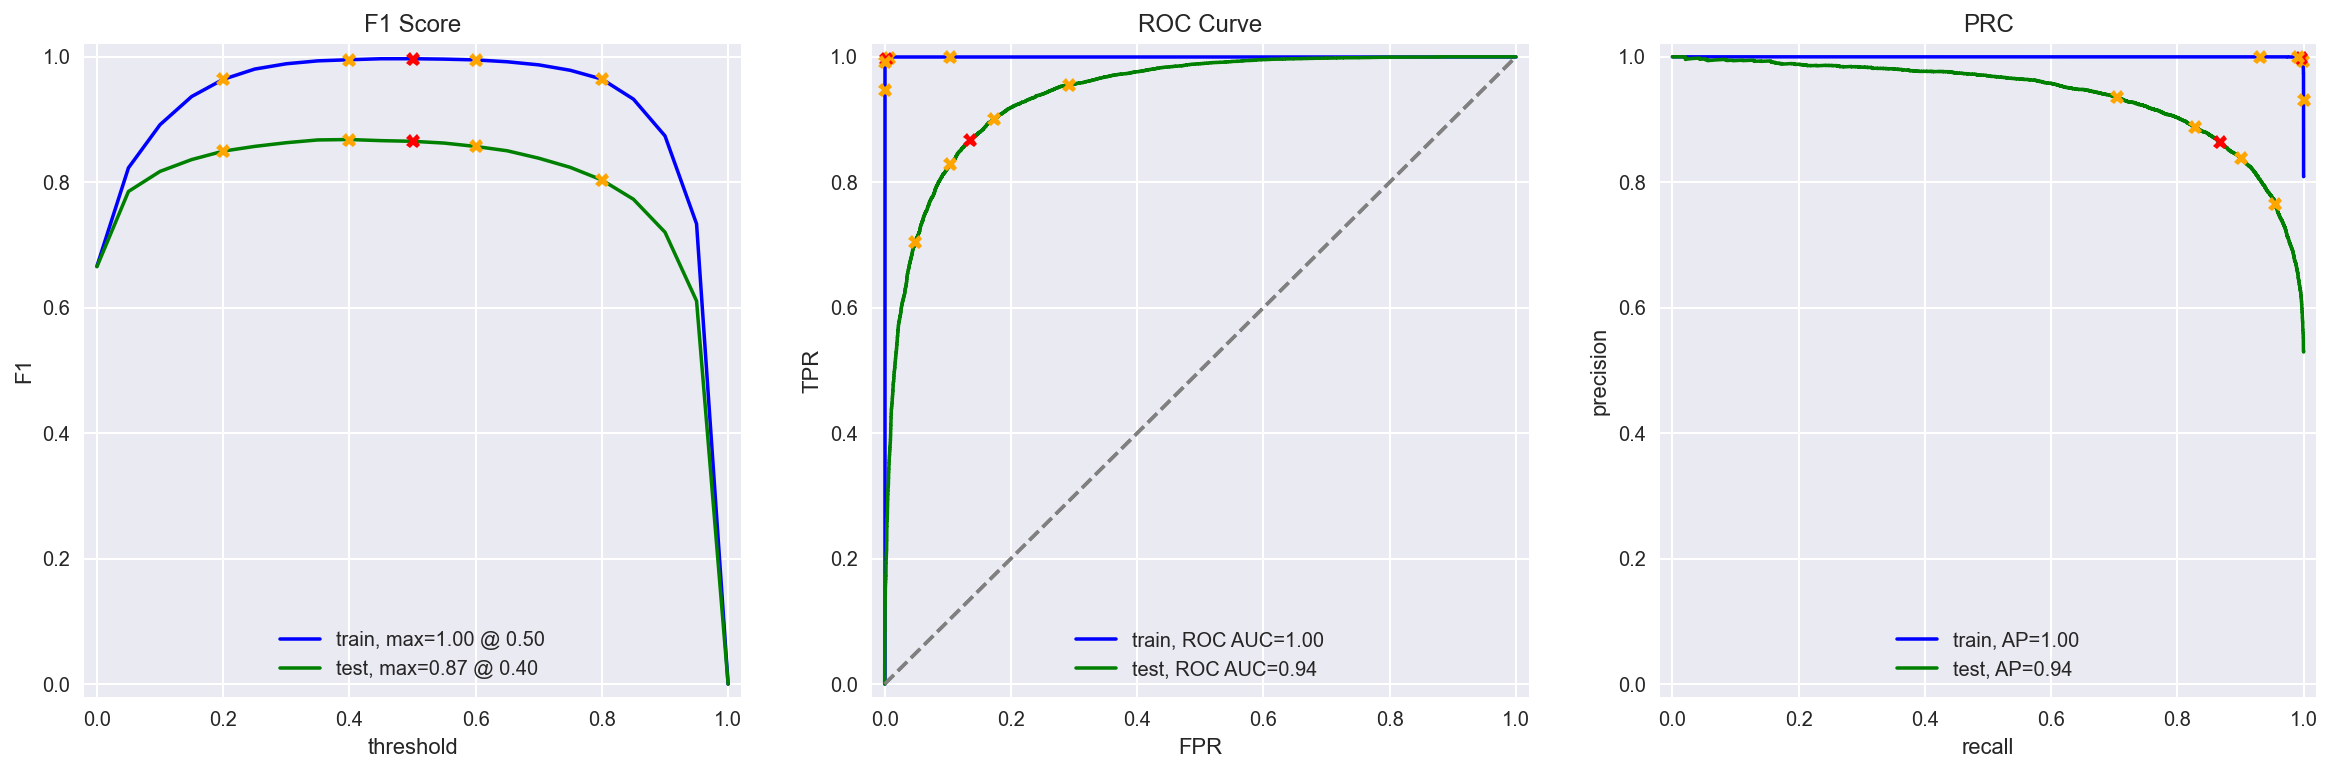

In [69]:
print_eval(models['CatBoost'], (X_train_w2v, X_test_w2v, y_train, y_test))

Despite the use of cross-validation in hyperopt, the model is severely overfitted.

### Save to list of best models

In [70]:
best_params = models['Logistic Regression']['best_params']
best_params.update(models['Logistic Regression']['other_params'])

best_w2v = models['Logistic Regression']['clf']
best_w2v.set_params(**best_params)
best_w2v.fit(X_train_w2v, y_train)

best_models['Word2Vec'] = {'vectorizer' : None, 'classifier' : best_w2v}

In this section, we vectorized the text using Word2Vec and made predictions using tuned logistic regression and CatBoost classifiers.  Both models exceeded the benchmark F1 score, and again, logistic regression slightly outperformed gradient boosting.

## Naive Bayes

### Preprocessing

In [71]:
# Convert series to sorted dictionary of words with their frequencies
def word_freq(series):
    return nltk.FreqDist(' '.join(series.values).split())

In [72]:
all_words = word_freq(X_train_nltk)
all_words

FreqDist({"'s": 59627, 'film': 46445, 'movie': 42218, "n't": 31880, 'one': 25544, 'make': 22472, 'like': 21302, 'see': 19807, 'get': 17300, 'time': 15382, ...})

In [73]:
# Designate 1000 words as potential features
WORD_FREQ_LIMIT = 1000

In [74]:
word_features = list(all_words)[:WORD_FREQ_LIMIT]

### Feature vectorization

In [75]:
def get_features(document):
    doc_set = set(document.split())
    return pd.Series([1 if w in doc_set else 0 for w in word_features])

In [76]:
X_train_nb = X_train_nltk.apply(get_features)

In [77]:
X_test_nb = X_test_nltk.apply(get_features)
X_test_nb.head(5)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Tuning: Feature selection

In [78]:
clf = MultinomialNB()

In [79]:
# Cross-validation to determine best feature cutoffs

best_score = 0
best_start = 0
best_end = WORD_FREQ_LIMIT

for s in range(0, 500, 25):
    for e in range(WORD_FREQ_LIMIT, 500, -25):
        scores = cross_val_score(clf, X_train_nb.loc[:,s:e], y_train, cv=CV, scoring=SCORING)
        best_score_cutoff = max(scores)
        
        if best_score_cutoff > best_score:
            best_score = best_score_cutoff
            best_start = s
            best_end = e

(best_start, best_end)

(25, 825)

Interestingly, on my system, values of (25, 850) were selected.  However, the improvement in F1 score was minor.

### Model evaluation

In [80]:
clf.fit(X_train_nb.loc[:,best_start:best_end], y_train)

MultinomialNB()

In [81]:
y_hat = clf.predict(X_test_nb.loc[:,best_start:best_end])

          train  test
Accuracy   0.84  0.83
F1         0.84  0.83
APS        0.90  0.90
ROC AUC    0.91  0.91


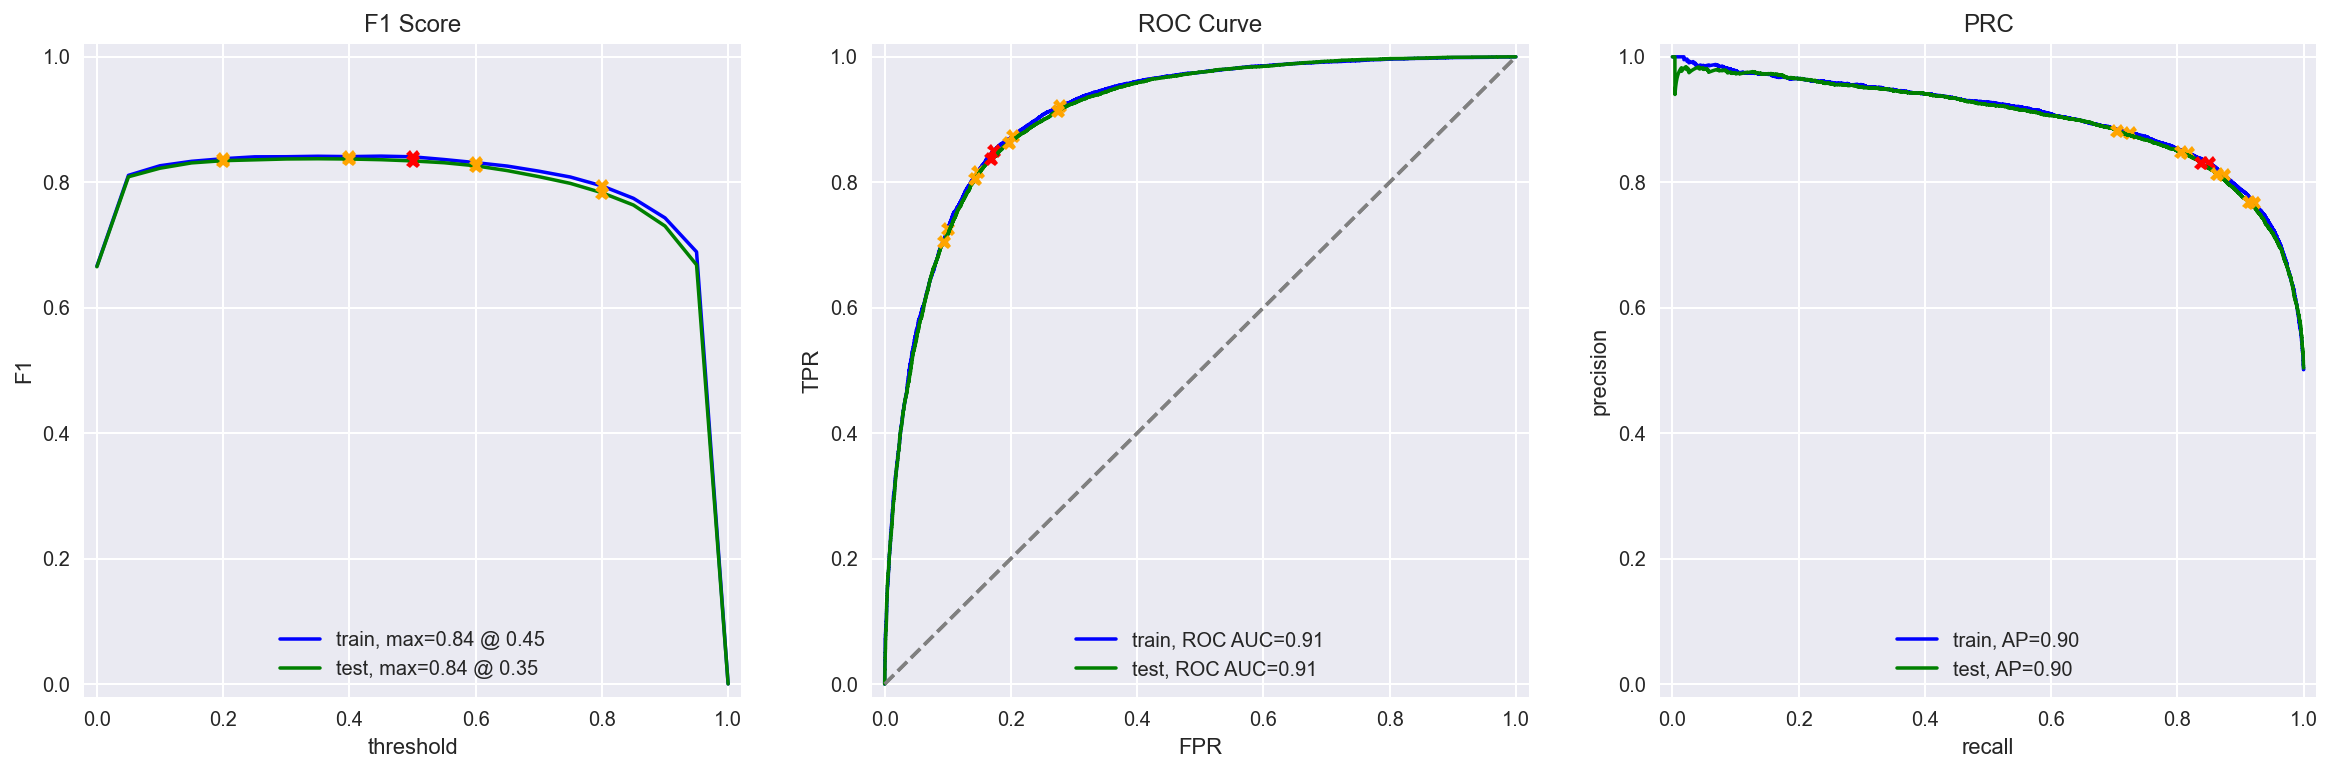

In [82]:
evaluate_model(clf, X_train_nb.loc[:,best_start:best_end], y_train, X_test_nb.loc[:,best_start:best_end], y_test)

### Save to list of best models

In [83]:
best_models['Naive Bayes'] = {'vectorizer' : get_features, 'classifier' : clf}

In this section, we vectorized the most frequent words and made predictions using the naive Bayes classifier.  There is little that can be done to tune the naive Bayes classifier, but we did use cross validation to determine which slice of the most frequent words to use as features.  This model failed to meet the benchmark F1 score.

## Conclusion: Sentiment analysis models
In this section, we experimented with vectorization with TF-IDF and Word2Vec, and predictive modeling using logistic regression and gradient boosting (LightGBM and CatBoost).  The F1 scores for the these models were all 0.87-0.88.

We also developed a naive Bayes model using the presence or absence of frequent words as features.  This simple model achieved an F1 score of 0.83.

# My Reviews

In [84]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

In [85]:
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text).apply(lemmatize_nltk)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",simply like kind movie
1,"Well, I was bored and felt asleep in the middl...",well bore felt asleep middle movie
2,I was really fascinated with the movie,really fascinate movie
3,Even the actors looked really old and disinter...,even actors look really old disinterested get ...
4,I didn't expect the reboot to be so good! Writ...,n't expect reboot good writers really care sou...
5,"The movie had its upsides and downsides, but I...",movie upsides downsides feel like overall 's d...
6,What a rotten attempt at a comedy. Not a singl...,rotten attempt comedy single joke land everyon...
7,Launching on Netflix was a brave move & I real...,launch netflix brave move really appreciate ab...


In [86]:
X_test = my_reviews['review_norm']

## Bag of words + logistic regression

In [87]:
bow_predict_prob = best_models['Bag of Words']['classifier'].predict_proba(
    best_models['Bag of Words']['vectorizer'].transform(X_test))[:, 1]

In [88]:
for i, review in enumerate(X_test.str.slice(0, 100)):
    print(f'{bow_predict_prob[i]:.2f}:  {review}')

0.43:  simply like kind movie
0.10:  well bore felt asleep middle movie
0.72:  really fascinate movie
0.18:  even actors look really old disinterested get pay movie soulless cash grab
0.12:  n't expect reboot good writers really care source material
0.68:  movie upsides downsides feel like overall 's decent flick could see go see
0.03:  rotten attempt comedy single joke land everyone act annoy loud even kid wo n't like
0.94:  launch netflix brave move really appreciate able binge episode episode excite intelligent new drama


All reviews were classified correctly except for the 5th one ("I didn't expect the reboot to be so good...").  This was a positive review, misclassified as negative.  Perhaps this is because some of the words used in the review are more commonly found in negative reviews, e.g., "reboot", "care" (which might be more common in the negative context of "don't care").

## TF-IDF + logistic regression

In [89]:
tfidf_predict_prob = best_models['TF-IDF']['classifier'].predict_proba(
    best_models['TF-IDF']['vectorizer'].transform(X_test))[:, 1]

In [90]:
for i, review in enumerate(X_test.str.slice(0, 100)):
    print(f'{tfidf_predict_prob[i]:.2f}:  {review}')

0.18:  simply like kind movie
0.05:  well bore felt asleep middle movie
0.84:  really fascinate movie
0.11:  even actors look really old disinterested get pay movie soulless cash grab
0.20:  n't expect reboot good writers really care source material
0.53:  movie upsides downsides feel like overall 's decent flick could see go see
0.03:  rotten attempt comedy single joke land everyone act annoy loud even kid wo n't like
0.90:  launch netflix brave move really appreciate able binge episode episode excite intelligent new drama


TF-IDF showed the same classifiation error as bag of words, likely for the same reason.

## Word2vec + logistic regression

In [91]:
my_reviews['review_w2v'] = my_reviews['review_norm'].apply(gensim.utils.simple_preprocess)

In [92]:
X_test_w2v = my_reviews['review_w2v'].apply(vectorize_review)

In [93]:
w2v_predict_prob = best_models['Word2Vec']['classifier'].predict_proba(X_test_w2v)[:, 1]

In [94]:
for i, review in enumerate(X_test.str.slice(0, 100)):
    print(f'{w2v_predict_prob[i]:.2f}:  {review}')

0.00:  simply like kind movie
0.00:  well bore felt asleep middle movie
0.86:  really fascinate movie
0.00:  even actors look really old disinterested get pay movie soulless cash grab
0.01:  n't expect reboot good writers really care source material
0.14:  movie upsides downsides feel like overall 's decent flick could see go see
0.00:  rotten attempt comedy single joke land everyone act annoy loud even kid wo n't like
1.00:  launch netflix brave move really appreciate able binge episode episode excite intelligent new drama


Word2vec had two misclassifications.  In addition to the error seen in the previous two models, Word2Vec misclassified the 6th review ("The movie had its upsides and downsides...").  This doesn't seem like a big error, however, as this was really a lukewarm review.

## Naive Bayes

In [95]:
nb_predict_prob = best_models['Naive Bayes']['classifier'].predict_proba(
    X_test.apply(best_models['Naive Bayes']['vectorizer']).loc[:,best_start:best_end])[:, 1]

In [96]:
for i, review in enumerate(X_test.str.slice(0, 100)):
    print(f'{nb_predict_prob[i]:.2f}:  {review}')

0.39:  simply like kind movie
0.18:  well bore felt asleep middle movie
0.50:  really fascinate movie
0.35:  even actors look really old disinterested get pay movie soulless cash grab
0.22:  n't expect reboot good writers really care source material
0.21:  movie upsides downsides feel like overall 's decent flick could see go see
0.04:  rotten attempt comedy single joke land everyone act annoy loud even kid wo n't like
0.94:  launch netflix brave move really appreciate able binge episode episode excite intelligent new drama


The naive Bayes model made the same mistakes as the Word2Vec model.  It also didn't really come to a decision on the 3rd review.

## Conclusion: Individual reviews

The models performed as expected on these samples, classifying 80-90% of reviews accurately.

Models like bag of words and TF-IDF do not take context into consideration, so the words themselves are what matters.  The 5th review, which all models misclassified, was very short and may have used words more commonly encountered in negative reviews.

The Word2Vec model has the potential to take context into consideration (e.g., the distinction between "care" vs. "don't care"), but this did not result in improved performance for these samples.  Word2vec might be expected to perform more poorly in part because these reviews are shorter than those in the IMDB dataset.

The 6th review was lukewarm, and interestingly, that is reflected in the probabilities assigned by most of the models.

# Conclusion
In this project, we solved a natural language binary classification problem:  the prediction of positive or negative polarity of IMDB movie reviews.  We experimented with:

- **Preprocessing libraries**:  NLTK slightly outperformed SpaCy
- **Vectorization methods**:  Bag of Words, TF-IDF, Word2Vec.  TF-IDF and Word2Vec offered similar performance.  Bag of Words didn't do as well.
- **Classifiers**:  Logistic regression, gradient boosting (LightGBM, CatBoost), and naive Bayes.  All except Bayes performed well, but logistic regression was easier to work with because of its speed and minimal tuning requirements.

Finally, we experimented with some out of sample reviews, and generally the models performed well.  The errors that did occur made have arisen from the specific wording used by the writer, vague/lukewarm reviews, and the brevity of reviews.